In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint    
import seaborn as sns
import datetime 
%matplotlib inline

# Pull Data

In [2]:
#path = "C:/Users/Akis-/OneDrive/Masters/Web Economics/Data/"
path = "C:/temp/kaggle/webeconomics/"
#test_df = pd.read_csv(path+'test.csv')
train_df = pd.read_csv(path+'train.csv')
validation_df = pd.read_csv(path+'validation.csv')
#train_df = pd.read_csv(path+'validation.csv')

In [3]:
#TotalImpressions = test_df.shape[0]
#print("TotalImpressions:",TotalImpressions)

In [65]:
#budget=6250*1000
#print("Our Budget is:",budget, "Fen")
#print("To use over",test_df.shape[0],"bid opportunities.")
#BudPerBid=budget/test_df.shape[0]
#print("Budget / Bid Opportunity:",BudPerBid)

minBid=np.min(train_df["payprice"].values)
maxBid=np.max(train_df["payprice"].values)

step_size = 1
custRange = np.arange(minBid+1, maxBid+5,step_size) # determines the range that bids should be in
#custRange = np.arange(60, 65,1)

minCustRange = np.arange(21, 91, step_size) # determines the range that bids should be in
maxCustRange = np.arange(71, 161, step_size) # determines the range that bids should be in

In [66]:
pd.set_option('display.max_columns', None)

# Functions

### Plot Metrics for bound combination for random bidding strategy

In [116]:
def plotResults(Matrix):

    ax = sns.heatmap(Matrix, linewidth=0, xticklabels=minCustRange, yticklabels=maxCustRange[::-1], cmap="Greens") #, annot=True
    ax.set(xlabel='lower bound for random bid', ylabel='upper bound for random bid', title="Clicks by bounded random bids")
    for label in ax.xaxis.get_ticklabels()[::1]:
        label.set_visible(False)
    for label in ax.xaxis.get_ticklabels()[::5]:
        label.set_visible(True)
    for label in ax.yaxis.get_ticklabels()[::1]:
        label.set_visible(False)
    for label in ax.yaxis.get_ticklabels()[::5]:
        label.set_visible(True)
        
#     for label in ax.xaxis.get_ticklabels()[::2]:
#         label.set_visible(False)    
#     for label in ax.yaxis.get_ticklabels()[::2]:
#         label.set_visible(False)    
        
        
    plt.savefig('RandomBidResults.png')
    plt.show()
    
    useless = 0
    return useless

### Build Matrix containing CTR for various bound combinations

In [68]:
def BuildCTRMatrix(dataframe,plot,repeats):
    #lastInRange = custRange[len(custRange)-1:][0]+1
    for n in range(0,repeats,1):
        dataSubset = dataframe.sample(frac=0.5, replace=False)
        print(n+1,"/",repeats,"...")
        
        for minimumBid in minCustRange:
            print('counting clicks',minimumBid,datetime.datetime.now().time())        
            for maximumBid in maxCustRange: #maxBid>minBid?????
                if maximumBid>minimumBid:
                    Clicks = EvalRandBidClicksOnly(dataSubset,minimumBid, maximumBid,6250000,validation_df.shape[0])
                    CTRMatrix[minimumBid][maximumBid]=(CTRMatrix[minimumBid][maximumBid]*n+Clicks)/(n+1)
        CTRMatrix.to_csv("RandomBidResults.csv")
    return CTRMatrix

### Extract best Bounds from Results Matrix

In [69]:
def FindBestBounds(ResultsMatrix):
    print("Best CTR is:",ResultsMatrix.values.max())
    for x in minCustRange:
        for y in maxCustRange:
            if ResultsMatrix[x][y]==ResultsMatrix.values.max():
                print("X:",x,"Y:",y)
                lowerBound=x
                upperBound=y
    return lowerBound, upperBound

### Evaluate a random bid value on a new set

In [70]:
#def EvalRandBid(dataframe,lowerBound, upperBound):
#    
#    dataframe['ConstBid'] = np.random.randint(lowerBound, upperBound+1, dataframe.shape[0])
#
#    trueValues = (dataframe["payprice"]<dataframe['ConstBid'])
#    impressions = dataframe[trueValues].shape[0]
#    clicks = np.sum(dataframe[trueValues]["click"].values)
#    ClickThroughRate=(clicks*100)/impressions
#        
#    return ClickThroughRate

In [71]:
def EvalRandBidClicksOnly(dataframe,lowerBound, upperBound,budget,size):
    
    AdjustedBudget=(budget/size)*dataframe.shape[0]
    #print("AdjustedBudget is:",AdjustedBudget)
    tempData=dataframe
    #tempData['ConstBid']=constant
    tempData['ConstBid'] = np.random.randint(lowerBound, upperBound+1, dataframe.shape[0])

    tempData['trueValues'] = np.where(tempData["payprice"]<tempData['ConstBid'],1,0)
    tempData['ModelPays'] = tempData['trueValues']*tempData['payprice']
    tempData['cumsum'] = tempData['ModelPays'].cumsum()
    lastRowToInclude = np.argmax(tempData['cumsum'].as_matrix()>AdjustedBudget)
    if lastRowToInclude==0:
        lastRowToInclude=tempData.shape[0]
    #print("lastRowToInclude",lastRowToInclude)
    
    shortData = tempData.head(lastRowToInclude)
    trueValues = (0<shortData['ModelPays'])
    ##impressions = shortData[trueValues].shape[0]
    clicks = np.sum(shortData[trueValues]["click"].values)
    ##spend = np.sum(shortData[trueValues]["payprice"].values)
    ##CostPerClick = spend/clicks
    ##CostPerMille = spend*1000/(impressions)
    ##ClickThroughRate=(clicks*100)/impressions
    #print(constant, ClickThroughRate, clicks, spend, CostPerMille, CostPerClick, impressions)
    #return [ClickThroughRate, clicks, spend, CostPerMille, CostPerClick, impressions]
    return clicks


    #impressions = shortData.loc[shortData['ModelPays'] > 0].sum()
    #clicks = shortData.loc[shortData['ModelPays'] > 0 , 'click'].sum()
    #print("clicks:",clicks)

In [72]:
def EvalRandBid(dataframe,lowerBound, upperBound,budget,size):
    
    AdjustedBudget=(budget/size)*dataframe.shape[0]
    #print("AdjustedBudget is:",AdjustedBudget)
    tempData=dataframe
    #tempData['ConstBid']=constant
    tempData['ConstBid'] = np.random.randint(lowerBound, upperBound+1, dataframe.shape[0])

    tempData['trueValues'] = np.where(tempData["payprice"]<tempData['ConstBid'],1,0)
    tempData['ModelPays'] = tempData['trueValues']*tempData['payprice']
    tempData['cumsum'] = tempData['ModelPays'].cumsum()
    lastRowToInclude = np.argmax(tempData['cumsum'].as_matrix()>AdjustedBudget)
    if lastRowToInclude==0:
        lastRowToInclude=tempData.shape[0]
    #print("lastRowToInclude",lastRowToInclude)
    
    shortData = tempData.head(lastRowToInclude).copy(True)
    trueValues = (0<shortData['ModelPays'])
    impressions = shortData[trueValues].shape[0]
    clicks = np.sum(shortData[trueValues]["click"].values)
    spend = np.sum(shortData[trueValues]["payprice"].values)
    CostPerClick = spend/clicks
    CostPerMille = spend*1000/(impressions)
    ClickThroughRate=(clicks*100)/impressions
    #print(constant, ClickThroughRate, clicks, spend, CostPerMille, CostPerClick, impressions)
    return [ClickThroughRate, clicks, spend, CostPerMille, CostPerClick, impressions]
    #return clicks


    #impressions = shortData.loc[shortData['ModelPays'] > 0].sum()
    #clicks = shortData.loc[shortData['ModelPays'] > 0 , 'click'].sum()
    #print("clicks:",clicks)

# Main Code

### Determine Best Bounds Combination from Train Set

In [73]:
zero_data = np.zeros(shape=(len(custRange),len(custRange)))
zero_data[zero_data < 1] = 0.0
CTRMatrix=pd.DataFrame(zero_data,index=reversed(custRange), columns=custRange)

In [74]:
CTRMatrix =  BuildCTRMatrix(train_df,plot=False,repeats=5)
#CTRMatrix.to_pickle("CTRMatrix.pkl")

1 / 5 ...
counting clicks 21 21:09:31.473298
counting clicks 22 21:10:29.633624
counting clicks 23 21:11:29.517049
counting clicks 24 21:12:28.604429
counting clicks 25 21:13:28.335845
counting clicks 26 21:14:27.811247
counting clicks 27 21:15:27.011633
counting clicks 28 21:16:23.846884
counting clicks 29 21:17:22.875260
counting clicks 30 21:18:22.521672
counting clicks 31 21:19:21.188027
counting clicks 32 21:20:21.096454
counting clicks 33 21:21:20.430848
counting clicks 34 21:22:21.279328
counting clicks 35 21:23:20.764730
counting clicks 36 21:24:19.738104
counting clicks 37 21:25:19.113500
counting clicks 38 21:26:18.363889
counting clicks 39 21:27:17.180253
counting clicks 40 21:28:16.158626
counting clicks 41 21:29:14.912987
counting clicks 42 21:30:15.275439
counting clicks 43 21:31:13.135749
counting clicks 44 21:32:11.311076
counting clicks 45 21:33:10.788478
counting clicks 46 21:34:08.597784
counting clicks 47 21:35:07.443150
counting clicks 48 21:36:06.750542
counting c

counting clicks 44 00:42:26.621994
counting clicks 45 00:43:25.042336
counting clicks 46 00:44:23.319669
counting clicks 47 00:45:21.458994
counting clicks 48 00:46:19.650323
counting clicks 49 00:47:17.357624
counting clicks 50 00:48:16.337997
counting clicks 51 00:49:14.399318
counting clicks 52 00:50:13.274685
counting clicks 53 00:51:10.989987
counting clicks 54 00:52:08.464274
counting clicks 55 00:53:06.915617
counting clicks 56 00:54:04.214894
counting clicks 57 00:55:01.405166
counting clicks 58 00:55:57.827393
counting clicks 59 00:56:54.968661
counting clicks 60 00:57:51.355886
counting clicks 61 00:58:48.235139
counting clicks 62 00:59:45.724428
counting clicks 63 01:00:42.636683
counting clicks 64 01:01:39.124914
counting clicks 65 01:02:34.630088
counting clicks 66 01:03:30.263271
counting clicks 67 01:04:25.747444
counting clicks 68 01:05:20.851596
counting clicks 69 01:06:13.950633
counting clicks 70 01:07:08.548756
counting clicks 71 01:08:02.744856
counting clicks 72 0

In [75]:
CTRMatrix.to_csv("RandomBidResults.csv")

In [52]:
#CTRMatrix = pd.read_pickle("CTRMatrix.pkl")

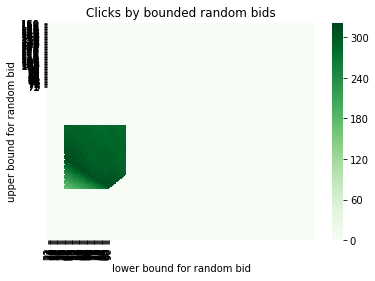

0

In [76]:
plotResults(CTRMatrix)

[21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45
 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90]
[ 71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160]


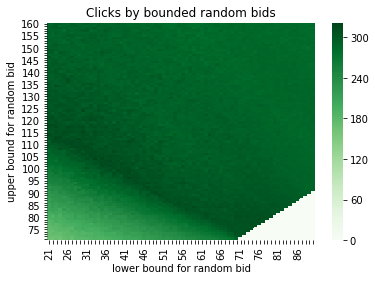

0

In [117]:
#CTRMatrix

print(minCustRange)

print(maxCustRange)

t = CTRMatrix.iloc[(304-160):(304-70),20:90]

plotResults(t)

In [118]:
lowBound, upBound = FindBestBounds(t)

Best CTR is: 322.0
X: 30 Y: 115


### Evalute on a new data set (validation set)

In [87]:
result = EvalRandBid(validation_df,lowBound, upBound,6250000,validation_df.shape[0])

In [89]:
#constant = result[0]
ClickThroughRate = result[0]
clicks = result[1]
spend = result[2]
CostPerMille = result[3]
CostPerClick = result[4]
impressions = result[5]

#print("constant",constant)
print("ClickThroughRate",ClickThroughRate)
print("clicks",clicks)
print("spend",spend)
print("CostPerMille",CostPerMille)
print("CostPerClick",CostPerClick)
print("impressions",impressions)

ClickThroughRate 0.05011735814699421
clicks 60
spend 6249903
CostPerMille 52204.771172495595
CostPerClick 104165.05
impressions 119719
